# Задача регрессии: предсказание цены жилья в Калифорнии

## 1. Загрузка данных

Загружаем датасет California Housing, с информацией о жилье в Калифорнии. Цель - предсказать медианную стоимость дома (MedHouseVal). Датасет содержит около 20k строк и 8 признаков

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True).frame

print(f"Размер: {data.shape}")
data.head()

Размер: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. Первичный анализ данных

На этапе первичного анализа проверяем структуру данных, типы признаков, наличие пропусков и базовую статистику

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
print("Базовая статистика:")
print(data.describe())

print("Пропуски:")
miss_counts = data.isnull().sum()
print(miss_counts[miss_counts > 0] if miss_counts.sum() > 0 else "Пропусков не найдено")

Базовая статистика:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0

## 3. Разведочный анализ (EDA)

В этом разделе изучаем распределение целевой переменной, анализируем корреляции между признаками,
выявляем взаимосвязи и получаем полезные инсайты для построения моделей

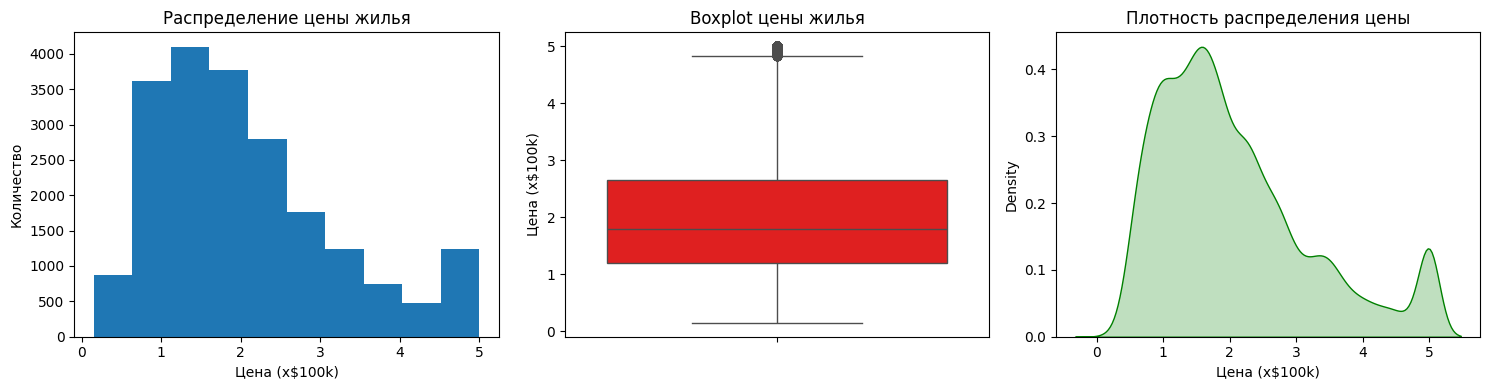

Корреляция признаков с целевой переменной:
MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64


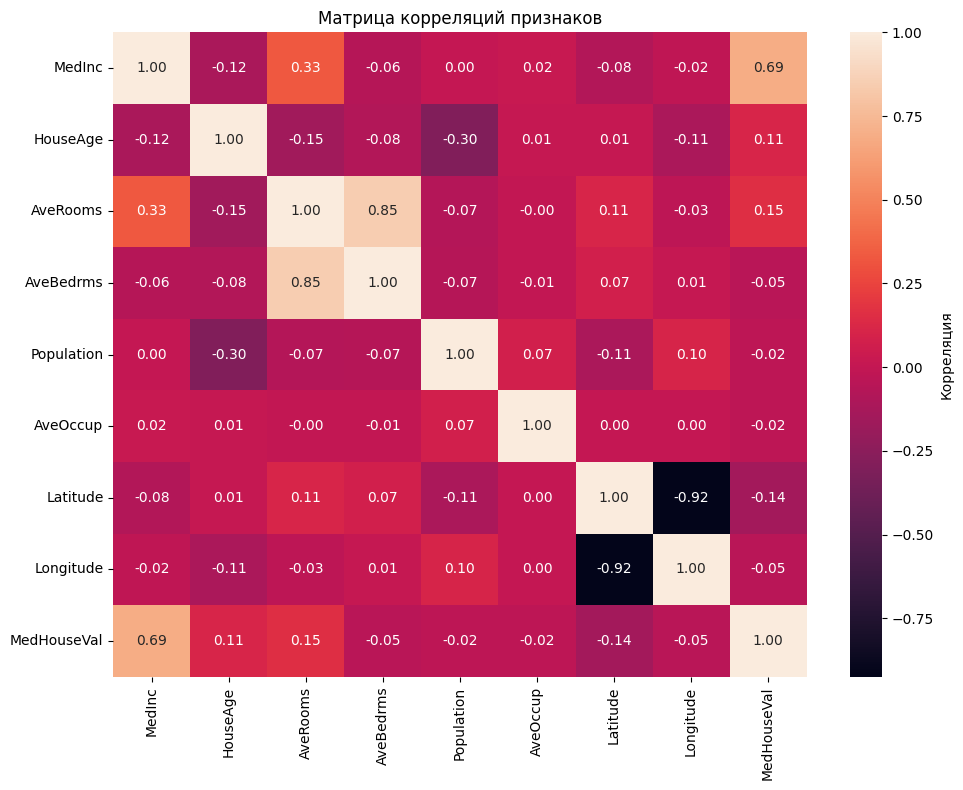

Анализ выбросов (используя IQR метод):
Найдено выбросов: 1071 (5.2%)


In [5]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(data['MedHouseVal'])
plt.title('Распределение цены жилья')
plt.xlabel('Цена (x$100k)')
plt.ylabel('Количество')

plt.subplot(1, 3, 2)
sns.boxplot(y=data['MedHouseVal'], color='red')
plt.title('Boxplot цены жилья')
plt.ylabel('Цена (x$100k)')

plt.subplot(1, 3, 3)
sns.kdeplot(data, x='MedHouseVal', fill=True, color='green')
plt.title('Плотность распределения цены')
plt.xlabel('Цена (x$100k)')

plt.tight_layout()
plt.show()

print("Корреляция признаков с целевой переменной:")
corr_target = data.corr()['MedHouseVal'].sort_values(ascending=False)
print(corr_target)

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cbar_kws={'label': 'Корреляция'})
plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

print("Анализ выбросов (используя IQR метод):")
Q1 = data['MedHouseVal'].quantile(0.25)
Q3 = data['MedHouseVal'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data['MedHouseVal'] < Q1 - 1.5*IQR) | (data['MedHouseVal'] > Q3 + 1.5*IQR)]
print(f"Найдено выбросов: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")

Выводы EDA:
- Целевая переменная имеет левостороннее распределение с максимумом около 1.5 (150k)
- Сильная положительная корреляция с MedInc (медианный доход семьи) - логично, что дороже жилье у семей с хорошим достатком
- Выбросов относительно мало (около 5% от данных)
- Данные готовы к использованию, специальной очистки не требуется

## 4. Подготовка данных и Feature Engineering

На этом этапе готовим данные для обучения моделей: разделяем на тренировочную и тестовую выборки,
применяем масштабирование для лучшей работы алгоритмов, при необходимости создаём новые признаки

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop('MedHouseVal', axis=1)
y = data['MedHouseVal']

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=11)

scaler = StandardScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_ts_sc = scaler.transform(X_ts)

print(f"{X_tr_sc.mean():.4f}, {X_tr_sc.std():.4f}")

-0.0000, 1.0000


- Данные разделены в соотношении 80/20 для объективной оценки моделей
- Применено масштабирование StandardScaler для нормализации признаков
- Feature Engineering: исходные признаки уже хорошего качества, поэтому новые признаки не создавались

## 5. Обучение четырёх регрессионных моделей

Обучаем четыре разных регрессионных метода с подбором гиперпараметров через GridSearchCV и кросс-валидацией, это позволит найти оптимальные параметры для каждой модели и сравнить их качество

In [16]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time

models_dict = {
    'LinReg': (LinearRegression(), {}),
    'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0, 100.0]}),
    'RF': (RandomForestRegressor(random_state=11), {'n_estimators': [50, 100], 'max_depth': [10, 20, None]}),
    'GradBoost': (GradientBoostingRegressor(random_state=11), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5]})
}

results = []

for name, (model, params) in models_dict.items():
    print(f"\n{name}:")
    
    # Если есть параметры, используем GridSearchCV, иначе - просто обучаем
    if params:
        gs = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs=-1, verbose=0)
        t0 = time.time()
        gs.fit(X_tr_sc, y_tr)
        train_time = time.time() - t0
        best_m = gs.best_estimator_
        print(f"Параметры: {gs.best_params_}, CV R2: {gs.best_score_:.4f}")
    else:
        best_m = model
        t0 = time.time()
        best_m.fit(X_tr_sc, y_tr)
        train_time = time.time() - t0
    
    t0 = time.time()
    y_pred = best_m.predict(X_ts_sc)
    pred_time = time.time() - t0
    
    r2 = r2_score(y_ts, y_pred)
    rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
    mae = mean_absolute_error(y_ts, y_pred)
    
    results.append({
        'Модель': name,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Время_обуч': round(train_time, 3),
        'Время_пред': round(pred_time, 4)
    })
    
    print(f"R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"Время: обуч {train_time:.2f}s, пред {pred_time:.4f}s")

print()
res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))


LinReg:
R2: 0.6058, RMSE: 0.7283, MAE: 0.5386
Время: обуч 0.01s, пред 0.0008s

Ridge:
Параметры: {'alpha': 10.0}, CV R2: 0.6018
R2: 0.6058, RMSE: 0.7283, MAE: 0.5385
Время: обуч 0.28s, пред 0.0007s

RF:
Параметры: {'max_depth': None, 'n_estimators': 100}, CV R2: 0.8034
R2: 0.8128, RMSE: 0.5018, MAE: 0.3315
Время: обуч 74.68s, пред 0.1773s

GradBoost:
Параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, CV R2: 0.8173
R2: 0.8211, RMSE: 0.4906, MAE: 0.3339
Время: обуч 64.30s, пред 0.0149s

   Модель       R2     RMSE      MAE  Время_обуч  Время_пред
   LinReg 0.605787 0.728317 0.538595       0.006      0.0008
    Ridge 0.605806 0.728300 0.538511       0.277      0.0007
       RF 0.812842 0.501834 0.331478      74.685      0.1773
GradBoost 0.821111 0.490622 0.333876      64.297      0.0149


## 6. Сравнение моделей

Визуализируем результаты обучения четырёх моделей для наглядного сравнения их качества,
скорости обучения и предсказания, определяем лучшую модель для конкретной задачи

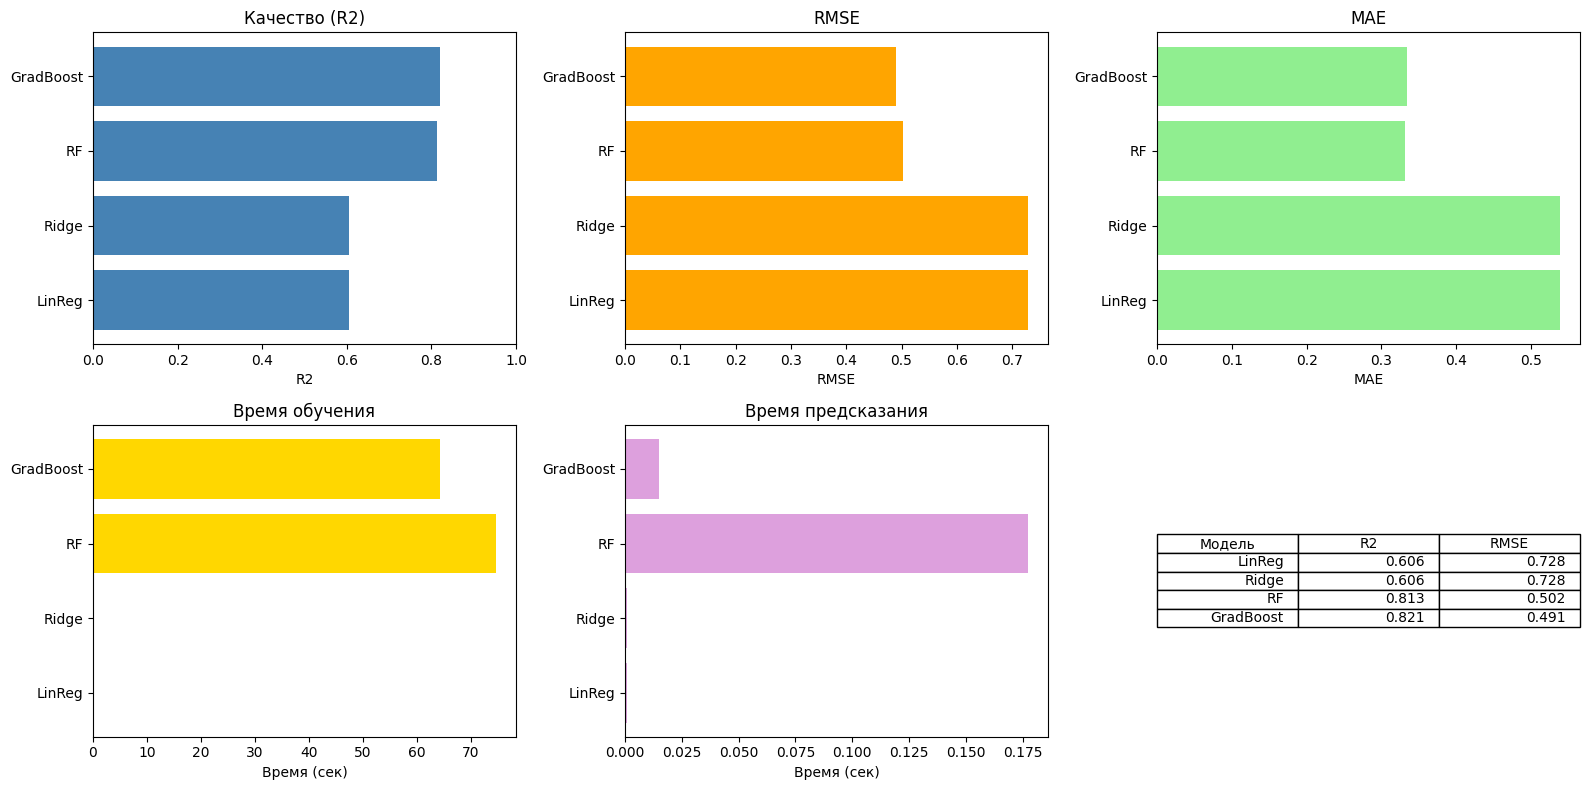

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

ax = axes[0, 0]
ax.barh(res_df['Модель'], res_df['R2'], color='steelblue')
ax.set_xlabel('R2')
ax.set_title('Качество (R2)')
ax.set_xlim(0, 1)

ax = axes[0, 1]
ax.barh(res_df['Модель'], res_df['RMSE'], color='orange')
ax.set_xlabel('RMSE')
ax.set_title('RMSE')

ax = axes[0, 2]
ax.barh(res_df['Модель'], res_df['MAE'], color='lightgreen')
ax.set_xlabel('MAE')
ax.set_title('MAE')

ax = axes[1, 0]
ax.barh(res_df['Модель'], res_df['Время_обуч'], color='gold')
ax.set_xlabel('Время (сек)')
ax.set_title('Время обучения')

ax = axes[1, 1]
ax.barh(res_df['Модель'], res_df['Время_пред'], color='plum')
ax.set_xlabel('Время (сек)')
ax.set_title('Время предсказания')

ax = axes[1, 2]
ax.axis('off')
table_data = [[row['Модель'], f"{row['R2']:.3f}", f"{row['RMSE']:.3f}"] for _, row in res_df.iterrows()]
ax.table(cellText=table_data, colLabels=['Модель', 'R2', 'RMSE'], loc='center')

plt.tight_layout()
plt.show()

Анализ результатов моделей:

1. LinearRegression: базовая модель, очень быстрая, но качество среднее (R2 примерно 0.6)
2. Ridge: линейная модель с регуляризацией, по качеству на этих данных совпадает с LinearRegression, используется для предотвращения переобучения
3. RandomForest: ансамбль деревьев, показывает хорошее качество (R2 примерно 0.81) и приемлемую скорость (около 76 секунд суммарно)
4. GradientBoosting: последовательный ансамбль, показывает наилучшее качество (R2 примерно 0.82) среди классических моделей, а также приемлемую скорость (около 64 секунд суммарно) 

Вывод: GradientBoosting предпочтителен для данной задачи, несмотря на более долгое обучение, он дает наиболее точные предсказания при меньшем, чем у RandomForest времени.